In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LinearRegression

from scipy import stats

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# caminho do google drive para leitura de dados
path = '/content/drive/MyDrive/AGRO/data_new/'

# Análise da série resposta



In [ ]:
# dados de rendimento (produtividade)
rend = pd.read_csv(path+'rendimento.csv', sep = ';', encoding = "ISO-8859-1")
# dados de produção bruta
prod = pd.read_csv(path+'producao.csv', sep = ';', encoding = "ISO-8859-1")

In [ ]:
# guardando os nomes dos municípios
municipios = rend['name'].values
# guardando os códigos IBGE dos municípios
codigos = prod[prod['Localidade'].isin(municipios)]['codigo_ibge'].values

In [ ]:
# geo DataFram com latitude e longitude dos municípios
position = pd.read_csv(path+'latlong.csv', sep = ',')

# criando um "geo DataFrame" com as coordenadas
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(position['longitude'], position['latitude'])]
geo_df = gpd.GeoDataFrame(position, 
                          crs = crs, 
                          geometry = geometry)

In [ ]:
# mapa do paraná com limites de municípios
mapa_pr = gpd.read_file('/content/drive/MyDrive/AGRO/shapefiles/PR_Municipios_2021.shp')
# selecionando apenas os municípios da região oeste
oeste_pr = mapa_pr[mapa_pr['NM_MUN'].isin(municipios)] 
# adicionando a produção média ao geo DataFrame
oeste_pr['PROD_MEDIA'] = prod['MEDIA'].values/1000         
# adicionando o rendimento médio ao geo DataFrame
oeste_pr['REND_MEDIA'] = rend['MEDIA'].values

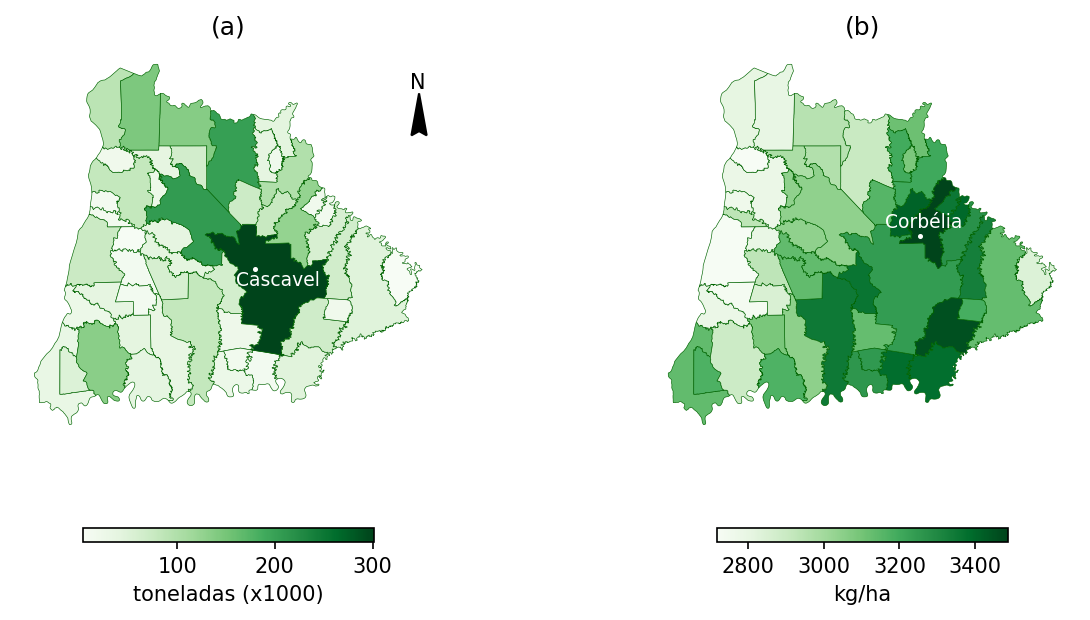

In [ ]:
# mapas de produção e produtividade média
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5), dpi = 150)

oeste_pr.plot(ax = ax[0], column = 'PROD_MEDIA', legend = True,
              legend_kwds = {'label': 'toneladas (x1000)', 'orientation': 'horizontal','shrink':0.55},
              cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)
geo_df[geo_df['nome']=='Cascavel'].plot(ax = ax[0], markersize = 2, color = 'white')
ax[0].annotate('Cascavel', xy = (-53.459,-24.9573), xytext=(11, -8), textcoords='offset points',
            ha='center' , fontsize = 9, color = 'white')
ax[0].axis("off")
ax[0].set_title('(a)')
ax[0].text(x=-52.65, y=-24.1, s='N', fontsize=10)
ax[0].arrow(-52.6, -24.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

oeste_pr.plot(ax = ax[1], column = 'REND_MEDIA', legend = True,
              legend_kwds = {'label': 'kg/ha', 'orientation': 'horizontal','shrink':0.55},
              cmap = 'Greens', edgecolor = 'darkgreen', linewidth = 0.3)
geo_df[geo_df['nome']=='Corbélia'].plot(ax = ax[1], markersize = 2, color = 'white')
ax[1].annotate('Corbélia', xy = (-53.3006,-24.7971), xytext=(2, 4), textcoords='offset points',
            ha='center' , fontsize = 9, color = 'white')
ax[1].axis("off")
ax[1].set_title('(b)')
plt.show()
#fig.savefig('prodrend.png')

In [ ]:
# Municípios top 10 em produtividade/rendimento
top10 = rend.sort_values(['MEDIA'],ascending = False).head(10)['name'].values

# criando um DF auxiliar
s_rend = pd.DataFrame(index = rend.columns[4:], columns = top10)
for i in top10:
  s_rend[i] = rend[rend['name']==i].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# adicionando a média de todos os 50 municípios
s_rend['Média']= rend.drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).mean(axis = 0)

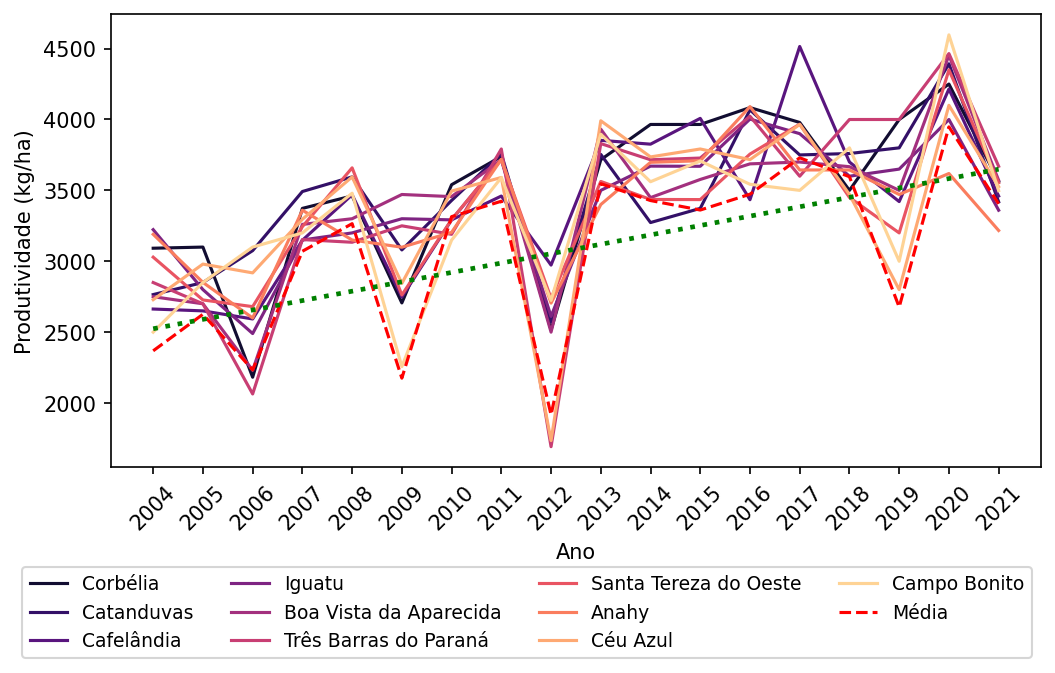

In [ ]:
# criando uma paleta de cores
import itertools
palette = itertools.cycle(sns.color_palette('magma', 10))

# gráfico dos municípios top 10 em rendimento
fig, ax = plt.subplots(figsize = (8,4), dpi = 150)

for i in top10:
  c = next(palette)
  sns.lineplot(ax = ax, x = np.arange(2004,2022), y = s_rend[i], color = c)

sns.lineplot(ax = ax, x=np.arange(2004,2022), y = s_rend['Média'], linestyle = '--', color = 'red')
sns.regplot(x=np.arange(2004,2022), y=s_rend['Média'].values, ci=None, scatter = False, line_kws={'color': 'green', 'linestyle': 'dotted'})
ax.set_xlabel('Ano', fontsize = 10)
ax.set_ylabel('Produtividade (kg/ha)', fontsize = 10)
ax.legend(s_rend.columns, bbox_to_anchor = (1, -0.2), fontsize = 9, ncol = 4)
plt.xticks(np.arange(2004, 2022, 1.0))
plt.xticks(rotation=45)
plt.show()
#fig.savefig('top10.png',bbox_inches='tight')

# Remoção da tendência das séries de produtividade

In [ ]:
# função que retorna a produtividade histórica dado o nome do município
def rend_city(nome):
  return rend[rend['name']==nome].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# função para remover a tendência da produtividade dado o nome do municipio
def remove_tend(nome):
  ys = rend_city(nome)
  ys = ys.reshape(len(ys), 1)
  xs = np.arange(2004,2022)
  xs = xs.reshape(len(xs), 1)
  lrc = LinearRegression()
  model = lrc.fit(xs, ys)
  pred = model.predict(xs)
  return ys - (pred.reshape(len(pred),1) - pred[0])

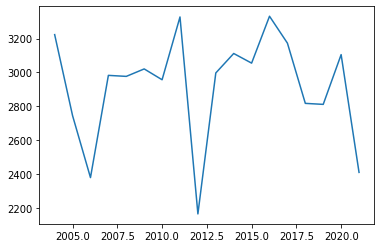

In [ ]:
# testando
y_new = remove_tend('Iguatu')

plt.plot(np.arange(2004,2022), y_new);

In [ ]:
# criando uma nova base de produtividade livre de tendência
rend_new = rend.copy()

for i in range(50):
  rend_new.loc[i, rend_new.columns[4:]] = remove_tend(municipios[i]).reshape(-1)

# update da produtividade média
medias = []
for i in range(50):
  medias.append(rend_new.loc[i, rend_new.columns[4:]].mean())

rend_new['MEDIA'] = medias

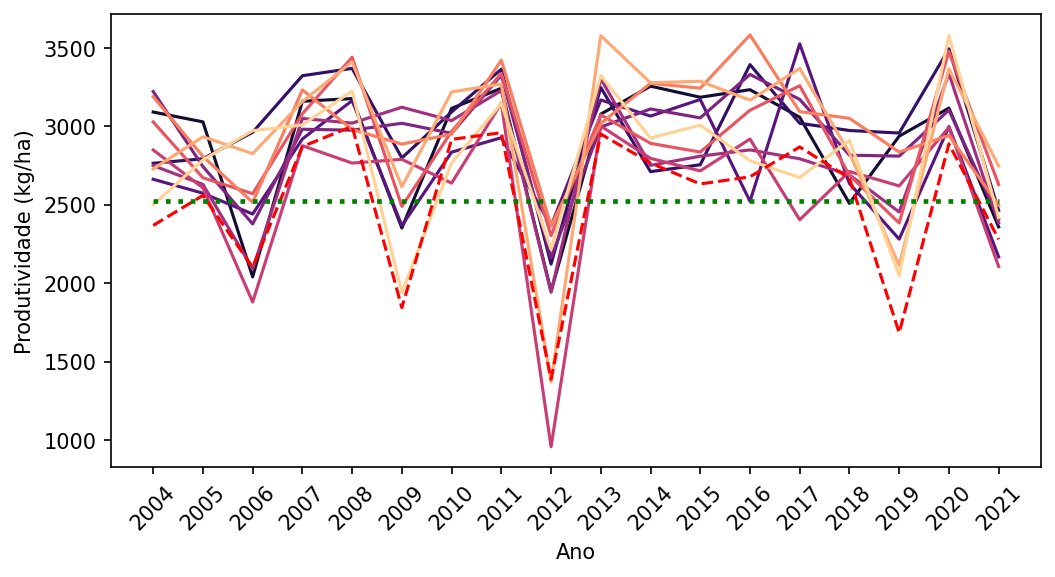

In [ ]:
# verificando
# criando um DF auxiliar
s_rend2 = pd.DataFrame(index = rend.columns[4:], columns = top10)
for i in top10:
  s_rend2[i] = rend_new[rend_new['name']==i].drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).iloc[0].values

# adicionando a média de todos os 50 municípios
s_rend2['Média']= rend_new.drop(['nivel','codigo_ibge','name','MEDIA'], axis = 1).mean(axis = 0)

# criando uma paleta de cores
palette = itertools.cycle(sns.color_palette('magma', 10))

# gráfico dos municípios top 10 em rendimento
fig, ax = plt.subplots(figsize = (8,4), dpi = 150)

for i in top10:
  c = next(palette)
  sns.lineplot(ax = ax, x = np.arange(2004,2022), y = s_rend2[i], color = c)

sns.lineplot(ax = ax, x=np.arange(2004,2022), y = s_rend2['Média'], linestyle = '--', color = 'red')
sns.regplot(x=np.arange(2004,2022), y=s_rend2['Média'].values, ci=None, scatter = False, line_kws={'color': 'green', 'linestyle': 'dotted'})
ax.set_xlabel('Ano', fontsize = 10)
ax.set_ylabel('Produtividade (kg/ha)', fontsize = 10)
#ax.legend(s_rend.columns, bbox_to_anchor = (1, -0.2), fontsize = 9, ncol = 4)
plt.xticks(np.arange(2004, 2022, 1.0))
plt.xticks(rotation=45)
plt.show()
# fig.savefig('top10_tend.png',bbox_inches='tight')

# Análise das séries preditoras

In [ ]:
# Mapas de clima
clima = pd.read_csv(path+'agroclima.csv')

In [ ]:
# Selecionando apenas os municípios do estudo
clima = clima[clima['codigo_ibge'].isin(codigos)]

In [ ]:
# adicionando a temperatura mínima é máxima média por município
oeste_pr['TMIN_MED'] = clima.groupby('codigo_ibge').mean()['T2M_MIN'].values
oeste_pr['TMAX_MED'] = clima.groupby('codigo_ibge').mean()['T2M_MAX'].values
# adicionando a precipitação acumulada por município
oeste_pr['PREC_ACC'] = clima.groupby('codigo_ibge').sum()['PRECTOTCORR'].values

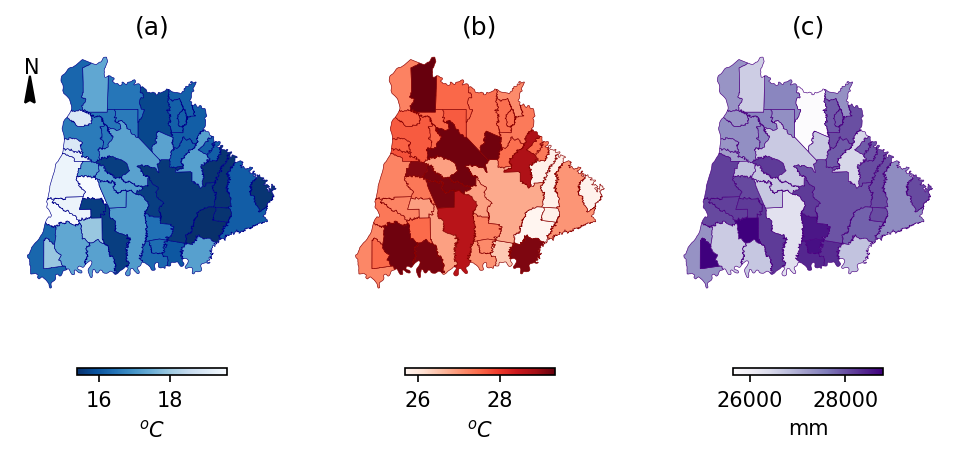

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (8,4), dpi = 150)

oeste_pr.plot(ax = ax[0], column = 'TMIN_MED', legend = True,
              legend_kwds = {'label': '$^o C$', 'orientation': 'horizontal','shrink':0.55},
              cmap = 'Blues_r', edgecolor = 'darkblue', linewidth = 0.3)
ax[0].axis("off")
ax[0].set_title('(a)')
ax[0].text(x=-54.65, y=-24.1, s='N', fontsize=10)
ax[0].arrow(-54.6, -24.3, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

oeste_pr.plot(ax = ax[1], column = 'TMAX_MED', legend = True,
              legend_kwds = {'label': '$^o C$', 'orientation': 'horizontal','shrink':0.55},
              cmap = 'Reds', edgecolor = 'darkred', linewidth = 0.3)
ax[1].axis("off")
ax[1].set_title('(b)')

oeste_pr.plot(ax = ax[2], column = 'PREC_ACC', legend = True,
              legend_kwds = {'label': 'mm', 'orientation': 'horizontal','shrink':0.55},
              cmap = 'Purples', edgecolor = 'indigo', linewidth = 0.3)
ax[2].axis("off")
ax[2].set_title('(c)')

plt.show()
#fig.savefig('clima.png')

In [ ]:
# convertendo os índices para o formato datetime
clima = clima.reset_index(drop = True)
clima.index = pd.to_datetime(clima['data'].astype(str), format='%Y%m%d')
# criando uma coluna com o ano do estudo
clima['data'] = clima.index
clima['ano'] = clima['data'].dt.year
# reorganizando colunas
clima = clima.iloc[:, [0,38]+np.arange(1,38).tolist()]
# dropando a coluna redundante 'data'
clima = clima.drop('data', axis = 1)

In [ ]:
# função para filtrar atributos de uma cidade em um determinado ano (ou todos)
def filtrar_cidade(cod,ano):
  aux = clima.loc[clima['codigo_ibge']==cod]
  if ano == 0:
    return aux
  else:
    return aux[aux['ano']==ano][aux.columns[4:]]

## Filtrando para os meses de interesse (01-set a 31-jan)

In [ ]:
# função para filtrar séries das cidades no período de interesse

def filtrar_clima(cod):
  cidade = filtrar_cidade(cod, 0).loc[str(2003)+'-09-01' : str(2004)+'-01-31'].drop('ano', axis = 1)
  cidade.insert(0,'safra',0)
  cidade['safra'] = np.repeat(2004, cidade.shape[0])

  for i in np.arange(2004,2020):
    ano = i
    aux = filtrar_cidade(cod, 0).loc[str(i)+'-09-01' : str(i+1)+'-01-31'].drop('ano', axis = 1)
    aux.insert(0,'safra',0)
    aux['safra'] = np.repeat(i+1, aux.shape[0])
    cidade = pd.concat((cidade, aux), axis = 0)
  return cidade

# Analisando as séries de:
- Corbélia (1ª posição em produtividade - 1/50);
- Ibema (17ª posição - 17/50);
- Nova Santa Rosa (33ª posição - 33/50);
- Mercedes (úlitima posição - 50/50).

In [ ]:
corb = filtrar_clima(codigos[10])
ibem = filtrar_clima(codigos[18])
nova = filtrar_clima(codigos[31])
merc = filtrar_clima(codigos[28])

In [ ]:
# colunas de cada classe de variáveis
temps = corb.columns[4:11]
umids = corb.columns[11:14]
winds = corb.columns[14:27]
solos = corb.columns[27:30]
eners = corb.columns[30:]

In [ ]:
# estudo de correlação entre atributos que permanecera na base
atrib = ['T2M_RANGE', 'T2M_MIN', 'T2M_MAX','QV2M', 'RH2M', 'PRECTOTCORR',
         'WS2M_RANGE','WS10M_RANGE','WS50M_RANGE','GWETTOP',
         'CLRSKY_SFC_PAR_TOT','ALLSKY_SFC_UVB','ALLSKY_SFC_UV_INDEX']

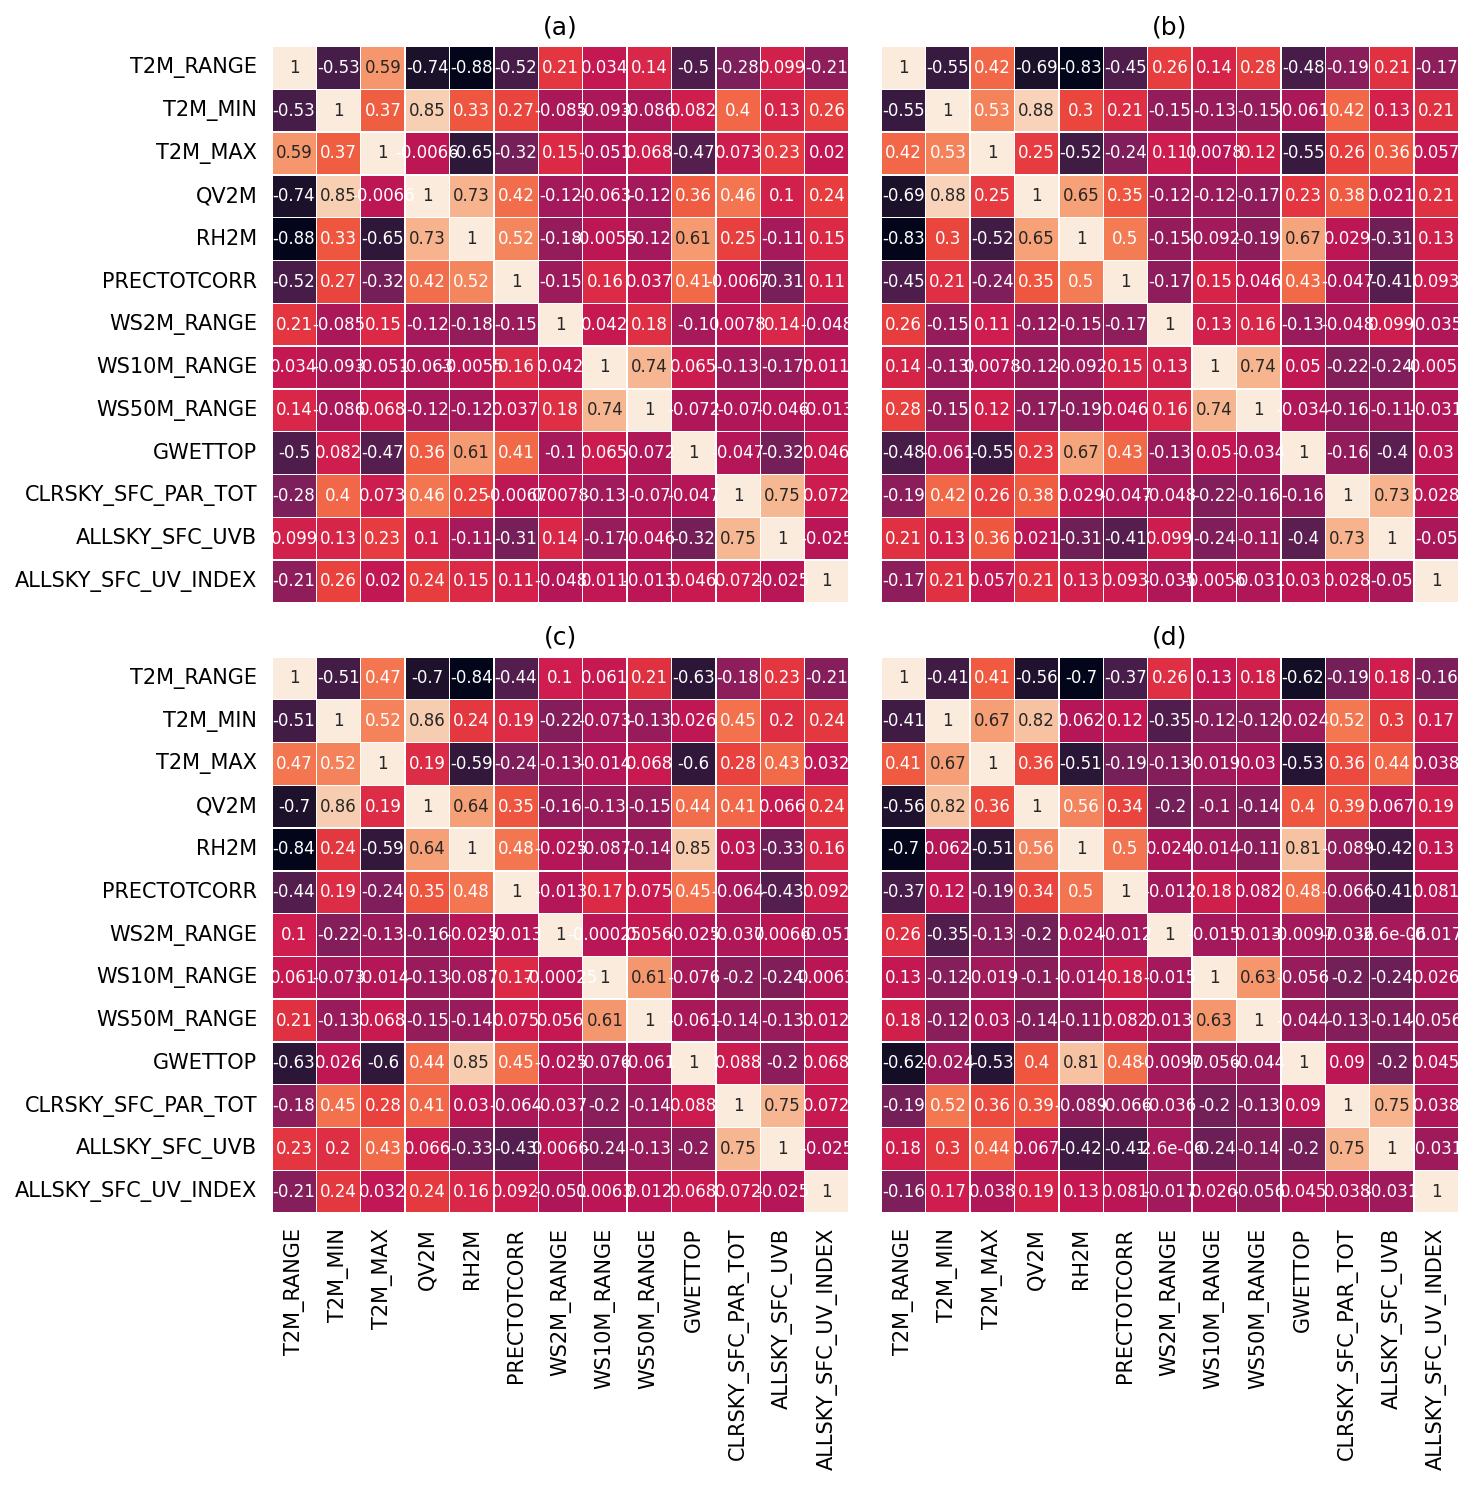

In [ ]:
# Mapas de calor para temperaturas
feats = atrib
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols = 2, sharey = True, figsize = (10,10), dpi = 150)

g1 = sns.heatmap(corb[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax1, annot_kws={"size":8})
g2 = sns.heatmap(ibem[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax2, annot_kws={"size":8})
g3 = sns.heatmap(nova[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax3, annot_kws={"size":8})
g4 = sns.heatmap(merc[feats].corr(), annot=True, cbar = False, linewidths=0.2, ax = ax4, annot_kws={"size":8})

g1.set(xticklabels=[], title = '(a)')
g1.tick_params(left = False, bottom=False)
g2.set(xticklabels=[], title = '(b)')
g2.tick_params(left = False, bottom=False)
g3.set(title = '(c)')
g3.tick_params(left = False, bottom=False)
g4.set(title = '(d)')
g4.tick_params(left = False, bottom=False)

fig = plt.gcf()

plt.tight_layout()
#fig.set_size_inches(12,6)
plt.show()

#fig.savefig('final_corr.png')

In [209]:
# base final de atributos
atrib = ['T2M_RANGE', 'T2M_MIN', 'T2M_MAX', 'PRECTOTCORR',
         'WS2M_RANGE','WS10M_RANGE','WS50M_RANGE','GWETTOP',
         'CLRSKY_SFC_PAR_TOT','ALLSKY_SFC_UVB','ALLSKY_SFC_UV_INDEX']

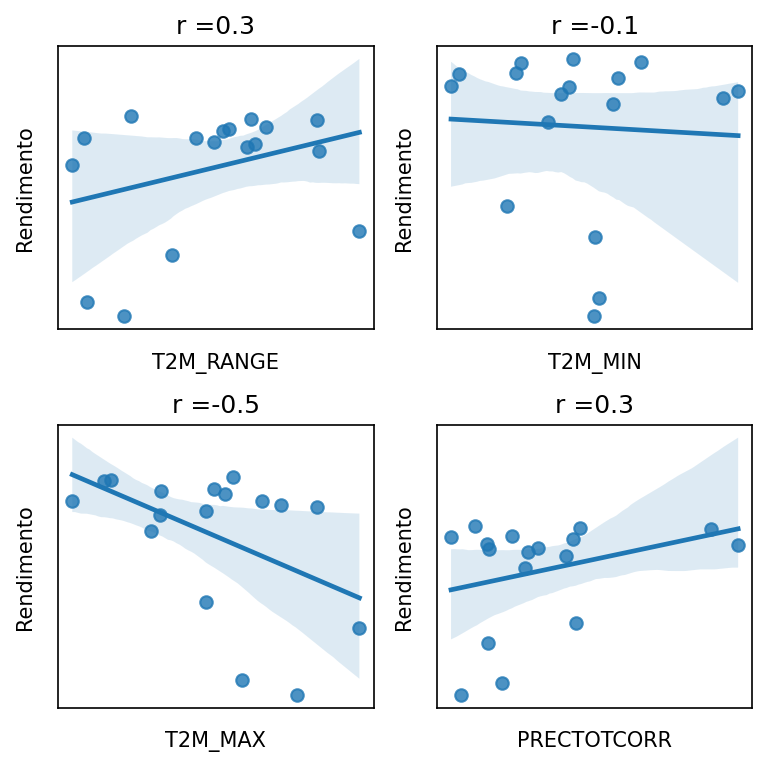

In [211]:
atribg = atrib[0:4]

b = rend_new[rend_new['name']=='Corbélia'][rend_new.columns[4:21]].values.reshape(-1)
px = [0,0,1,1]
py = [0,1,0,1]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6), 
                       constrained_layout = True, dpi = 150)

for i in np.arange(0,len(atribg)):
  a = corb.groupby('safra').median()[atribg[i]].values # agregador mediana
  # a = corb.groupby('safra').apply(lambda x: x.quantile(0.75)-x.quantile(0.25))[atribg[i]].values # agregador distância interquartil
  

  r, pval = stats.pearsonr(a,b)
  r = round(r,1)

  sns.regplot(a,b, ax = ax[px[i],py[i]])

  ax[px[i],py[i]].set(xticklabels=[], yticklabels=[], title = 'r ='+str(r),
                      xlabel = atribg[i], ylabel = 'Rendimento')
  ax[px[i],py[i]].tick_params(left = False, bottom=False)

fig.set_size_inches(5,5)
plt.show()

#fig.savefig('climarend3.png')

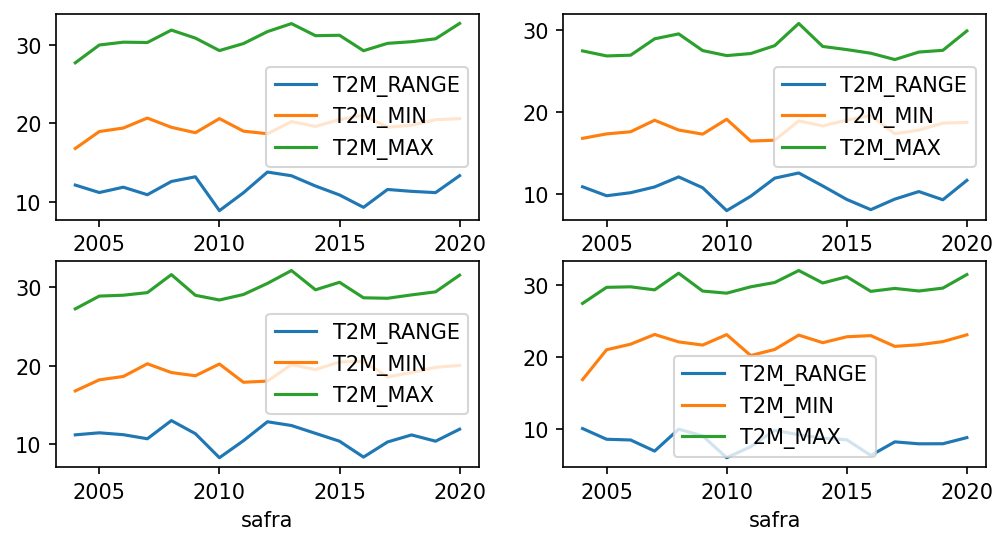

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,4), dpi = 150)

corb.groupby('safra').median()[atrib[0:3]].plot(ax = ax[0,0]);
ibem.groupby('safra').median()[atrib[0:3]].plot(ax = ax[0,1]);
nova.groupby('safra').median()[atrib[0:3]].plot(ax = ax[1,0]);
merc.groupby('safra').median()[atrib[0:3]].plot(ax = ax[1,1]);

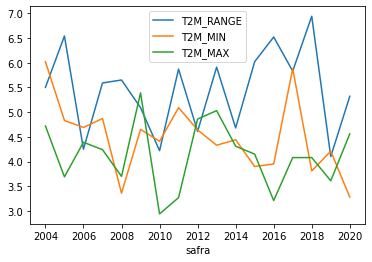

In [ ]:
corb.groupby('safra').apply(lambda x: x.quantile(0.75)-x.quantile(0.25))[atrib[0:3]].plot();

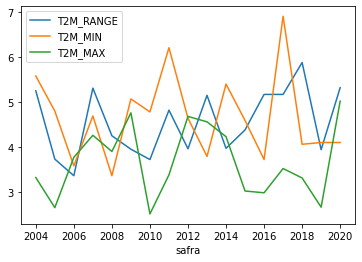

In [ ]:
ibem.groupby('safra').apply(lambda x: x.quantile(0.75)-x.quantile(0.25))[atrib[0:3]].plot();

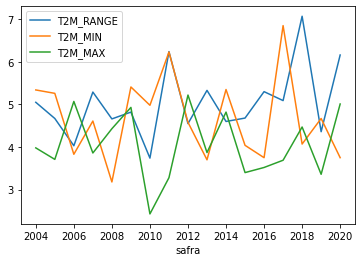

In [ ]:
nova.groupby('safra').apply(lambda x: x.quantile(0.75)-x.quantile(0.25))[atrib[0:3]].plot();

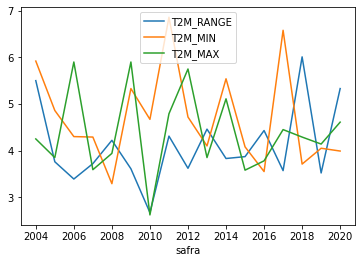

In [ ]:
merc.groupby('safra').apply(lambda x: x.quantile(0.75)-x.quantile(0.25))[atrib[0:3]].plot();